# Zalando Clother Classification - Modeling and testing

__Author: Fernández Hernández, Alberto__

__Date: 2023 - 10 - 26__

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.7 MB/s eta 0:00:00


In [2]:
# -- Libraries
from   sklearn.model_selection import train_test_split
from   sklearn.utils           import class_weight
from   sklearn                 import metrics
from   torchvision             import models
from   tqdm                    import tqdm
from   torch.utils             import data
import torch.nn.functional     as F
import torch.nn                as nn
import matplotlib.pyplot       as plt
import numpy                   as np
import pandas                  as pd
import torchvision.transforms  as transforms
import itertools
import torch
import shap
import math
import gzip
import os

In [3]:
# -- Constants and parameters
MAIN_PATH       = '/content/drive/MyDrive/Personal/CentricSoftware'
NPY_FILES       = MAIN_PATH + '/images/'
MODELS_PATH     = MAIN_PATH + '/models/'
MODEL_NAME      = f'{MODELS_PATH}/02_zalando_image_classification_mobilenet_v2_baseline_non_layers_frozen.pth'
BATCH_SIZE      = 16
RANDOM_STATE    = 1234
EPOCHS          = 15
PATIENT         = 3
LEARNING_RATE   = 5e-05
LOSS_IMPROVE    = 1e-04
MAX_PIXEL_VALUE = 255
NUM_LABELS      = 5
IMG_SIZE        = 224

# -- Specify seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

LABEL_MAPPING = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

CATEGORY_MAPPING = {
    "T-shirt/top": "Upper part",
    "Pullover": "Upper part",
    "Coat": "Upper part",
    "Shirt": "Upper part",
    "Trouser": "Bottom part",
    "Dress": "One piece",
    "Sandal": "Footwear",
    "Sneaker": "Footwear",
    "Ankle boot": "Footwear",
    "Bag": "Bags"
}

GROUP_MAPPING = {
    "Upper part": 0,
    "Bottom part": 1,
    "One piece": 2,
    "Footwear": 3,
    "Bags": 4
}

REVERSE_GROUP_MAPPING = dict((v, k) for k, v in GROUP_MAPPING.items())

In [6]:
f=gzip.open('/content/drive/MyDrive/Personal/CentricSoftware/t10k-images-idx3-ubyte.gz','rb')
file_content=f.read()

In [7]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## Load data

In [8]:
X_train, y_train = load_mnist('/content/drive/MyDrive/Personal/CentricSoftware', kind='train')

X_train          = np.reshape(X_train, (X_train.shape[0],
                                        int(math.sqrt(X_train.shape[1])),
                                        int(math.sqrt(X_train.shape[1]))
                                        )
                   )

X_test, y_test   = load_mnist('/content/drive/MyDrive/Personal/CentricSoftware', kind='t10k')

X_test           = np.reshape(X_test, (X_test.shape[0],
                                        int(math.sqrt(X_test.shape[1])),
                                        int(math.sqrt(X_test.shape[1]))
                                        )
                   )

## Convert labels into groups

In [9]:
# -- Train labels
y_train_df = pd.DataFrame({'label': y_train})
y_train_df['label_str'] = y_train_df['label'].map(LABEL_MAPPING)

# -- Test labels
y_test_df = pd.DataFrame({'label': y_test})
y_test_df['label_str'] = y_test_df['label'].map(LABEL_MAPPING)

# -- Convert to groups
y_train_df['category'] = y_train_df['label_str'].map(CATEGORY_MAPPING)
y_test_df['category']  = y_test_df['label_str'].map(CATEGORY_MAPPING)

# -- Filter and rename columns
y_train_df = pd.DataFrame(y_train_df['category'].apply(lambda x: GROUP_MAPPING[x]))
y_test_df  = pd.DataFrame(y_test_df['category'].apply(lambda x: GROUP_MAPPING[x]))

y_train_df.rename(columns={'category': 'label'}, inplace=True)
y_test_df.rename(columns={'category': 'label'}, inplace=True)

### Perform train & validation split

In [10]:
y_train_df.reset_index(inplace=True)
X, y = y_train_df[['index']], y_train_df[['label']]
_, _, y_train_df, y_val_df = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [11]:
y_train_df.value_counts(sort=False)

label
0        19200
1         4800
2         4800
3        14400
4         4800
dtype: int64

In [12]:
y_val_df.value_counts(sort=False)

label
0        4800
1        1200
2        1200
3        3600
4        1200
dtype: int64

### Save images as .npy files

In [13]:
y_train_df.reset_index(inplace=True), y_val_df.reset_index(inplace=True), y_test_df.reset_index(inplace=True)

(None, None, None)

In [18]:
!mkdir $NPY_FILES
train_indexes_list = list(y_train_df['index'])
for index_ in tqdm(train_indexes_list):
  np.save(NPY_FILES + 'train_image_{:05d}.npy'.format(index_), X_train[int(index_)])

100%|██████████| 48000/48000 [03:52<00:00, 206.04it/s]


In [19]:
validation_indexes_list = list(y_val_df['index'])
for index_ in tqdm(validation_indexes_list):
  np.save(NPY_FILES + 'validation_image_{:05d}.npy'.format(index_), X_train[int(index_)])

100%|██████████| 12000/12000 [00:57<00:00, 206.92it/s]


In [20]:
test_indexes_list = list(y_test_df['index'])
for index_ in tqdm(test_indexes_list):
  np.save(NPY_FILES + 'test_image_{:05d}.npy'.format(index_), X_test[int(index_)])

100%|██████████| 10000/10000 [00:48<00:00, 207.57it/s]


__Get mean and standard deviation__

NOTE: MEAN and STD must be extracted ONLY from the training set

In [21]:
train_indexes_list = list(y_train_df['index'])
MEAN = np.mean(X_train[train_indexes_list,:,:]); STD = np.std(X_train[train_indexes_list,:,:])
MEAN, STD

(72.96911585884354, 90.03119247281305)

In [22]:
# -- Save labels as .csv files
y_train_df.to_csv(MAIN_PATH + '/train_labels.csv', sep=';', index=False)
y_val_df.to_csv(MAIN_PATH + '/val_labels.csv', sep=';', index=False)
y_test_df.to_csv(MAIN_PATH + '/test_labels.csv', sep=';', index=False)

# Define Model Architecture

In [40]:
# Step 1. Define ZalandoDataset class
class ZalandoDataset(data.Dataset):
    def __init__(self, transform=False, data_type='Train', images_list=None):
        super().__init__()
        self.transform    = transform
        self.data_type    = data_type
        self.images_list  = images_list
        self.records      = None

        if self.data_type == 'Train':
            self.labels      = pd.read_csv(MAIN_PATH + '/train_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'train_image' in file_]
        elif self.data_type == 'Validation':
            self.labels      = pd.read_csv(MAIN_PATH + '/val_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'validation_image' in file_]
        elif self.data_type == 'Test':
            self.labels      = pd.read_csv(MAIN_PATH + '/test_labels.csv', sep=';')
            self.records     = [NPY_FILES + file_ for file_ in images_list if 'test_image' in file_]
        else:
          assert False, "data_type not admitted. Options available: Train, Validation or Test"

        # Label weights (inverse classes balance)
        labels_list   = list(self.labels['label'])
        weights_      = class_weight.compute_class_weight(class_weight='balanced',
                                                          classes=np.unique(labels_list),
                                                          y=np.array(labels_list))
        self.weights  = torch.FloatTensor(weights_)

        self.transforms = transforms.Compose([
                                transforms.Lambda(lambda x: x.unsqueeze(0).unsqueeze(0)),
                                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.Normalize((MEAN,), (STD,)),
                                transforms.Lambda(lambda x: x.squeeze(0,1))
                            ])


    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.records)

    def __getitem__(self, index):
        # Load raw image data for each plane
        path    = self.records[index]
        image_id= int(path.split('_')[-1].replace('.npy', ''))
        img_raw = np.load(path)

        # Standarize data
        img_raw = torch.FloatTensor(img_raw)
        img_raw = self.transforms(img_raw)
        img_raw = img_raw.expand(3, img_raw.size(0), img_raw.size(1))

        label = list(self.labels[self.labels['index'] == image_id]['label'])
        label = torch.tensor(label)

        # Return pre-processed image and label
        return img_raw, label

In [41]:
# -- Number of total images: 70k
image_list = os.listdir(NPY_FILES)
len(image_list)

70000

In [42]:
# Get dataset
train_dataset = ZalandoDataset(images_list=image_list)
val_dataset   = ZalandoDataset(data_type='Validation', images_list=image_list)
test_dataset  = ZalandoDataset(data_type='Test', images_list=image_list)

In [43]:
train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=BATCH_SIZE,
                shuffle=True, drop_last=False, num_workers=2)

val_loader  =  torch.utils.data.DataLoader(
                val_dataset, batch_size=BATCH_SIZE,
                shuffle=False, drop_last=False, num_workers=2)

test_loader =  torch.utils.data.DataLoader(
                test_dataset, batch_size=BATCH_SIZE,
                shuffle=False, drop_last=False, num_workers=2)

## Define the Conv. Model

In [44]:
class CustomMobileNetV2(nn.Module):
    """
    Define MobileNetV2 architecture, which consists of:
      - MobileNetV2
        - Conv2d
        - ...
        - nn.Linear(1280, num_classes)
    """
    def __init__(self, num_classes=NUM_LABELS):
        super(CustomMobileNetV2, self).__init__()

        # -- Load pretrained MobileNetV2
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)

        # -- NEW IN VERSION 02 - Freeze convolutional layers
        # for param in self.mobilenet_v2.parameters():
        #    param.requires_grad = False

        # -- Replace last layer for final FC with num_classes outputs
        self.mobilenet_v2.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [45]:
model = CustomMobileNetV2()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.


## Error + Callbacks

In [46]:
# Define error criterion and optimize functions
train_criterion = nn.CrossEntropyLoss(weight = train_dataset.weights)
val_criterion   = nn.CrossEntropyLoss(weight = val_dataset.weights)

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=0.01)
# Define callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
              optimizer, patience=3, factor=0.3, threshold=1e-4, verbose=True
)

## Define metrics

In [47]:
def get_metrics(y_true, y_pred):
    """
    Calculate recall (sensitivity), precision and negative predicted value (NPV) for a multi-class image classification task with N classes.

    Args:
    y_true (list): True labels (ground truth) for each sample.
    y_pred (list): Predicted labels for each sample.

    Returns:
    dict: A dictionary containing recall, precision and NPV for each class.
    """
    classes = range(5)
    sensitivity = {}  # Recall
    precision = {}
    npv = {}

    for c in classes:
        # Calculate True Positives (TP), False Negatives (FN), and False Positives (FP) for each class
        TP = sum((y_true[i][c] == 1) and (y_pred[i][c] == 1) for i in range(len(y_true)))
        TN = sum((y_true[i][c] == 0) and (y_pred[i][c] == 0) for i in range(len(y_true)))
        FN = sum((y_true[i][c] == 1) and (y_pred[i][c] == 0) for i in range(len(y_true)))
        FP = sum((y_true[i][c] == 0) and (y_pred[i][c] == 1) for i in range(len(y_true)))

        # Calculate recall (sensitivity) and precision for each class
        sensitivity[REVERSE_GROUP_MAPPING[c]] = TP / (TP + FN) if (TP + FN) > 0 else 0
        precision[REVERSE_GROUP_MAPPING[c]] = TP / (TP + FP) if (TP + FP) > 0 else 0
        npv[REVERSE_GROUP_MAPPING[c]] = TN / (TN + FN) if (TN) > 0 else 0

    return {"recall": sensitivity, "precision": precision, "negative predicted value": npv}

## Define training and validation metrics

In [48]:
# -- Transform predicted values into one-shot
def maximize_index(predicted_values):
  max_indices = np.argmax(predicted_values, axis=1)
  result = np.zeros_like(predicted_values)
  for i in range(result.shape[0]):
      result[i, max_indices[i]] = 1
  return result

In [49]:
# -- Define train function
def train(train_data, model, criterion):
    print('Training...')
    model.train()
    counter = 0
    train_running_loss    = 0.0
    prediction_list       = []
    prediction_proba_list = []
    for input_data, label in tqdm(train_data):
        # Switch to GPU if available
        if torch.cuda.is_available():
            input_data, label = input_data.cuda(), label.cuda()
        counter += 1
        optimizer.zero_grad()
        outputs = model(input_data)

        # Apply softmax activation to get all the outputs between 0 and 1
        outputs_sig  = F.softmax(outputs.data, dim=1).detach().cpu()
        prediction_proba_list.append(itertools.chain(*outputs_sig))
        prediction_list.append(itertools.chain(maximize_index(outputs_sig.numpy())))

        # Loss
        loss     = criterion(outputs.cpu(), label.squeeze(-1).cpu())
        train_running_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update optimizer parameters
        optimizer.step()
    train_loss       = train_running_loss  / counter
    return train_loss, prediction_list

In [50]:
# Define val function
def val(val_data, model, criterion):
    print('Validating...')
    model.eval()
    counter = 0
    val_running_loss      = 0.0
    total                 = 0.0
    prediction_list       = []
    prediction_proba_list = []
    label_list            = []
    label_one_hot         = []

    with torch.no_grad():
      for input_data, label in tqdm(val_data):
          # Again, switch to GPU if available
          if torch.cuda.is_available():
              input_data, label = input_data.cuda(), label.cuda()

          label_numpy   = label.detach().cpu().numpy()
          for label_ in label_numpy:
            label_one_hot_aux = np.zeros(NUM_LABELS)
            label_one_hot_aux[label_] = 1
            label_one_hot.append(label_one_hot_aux)

          label_list.append(label_numpy)
          counter += 1
          outputs  = model(input_data)

          # Apply softmax activation to get all the outputs between 0 and 1
          outputs_sig = F.softmax(outputs.data, dim=1).detach().cpu()
          prediction_proba_list.append(outputs_sig)
          prediction_list.append(maximize_index(outputs_sig.numpy()))
          total    += label.size(1)

          # Loss
          loss     = criterion(outputs.cpu(), label.squeeze(-1).cpu())
          val_running_loss += loss.item()

      val_loss     = val_running_loss / counter
      # Get Sensitivity/Precision/NPV
      prediction_list = list(itertools.chain(*prediction_list))
      label_list      = list(itertools.chain(*label_list))
      prediction_proba_list = list(itertools.chain(*prediction_proba_list))
      metric_dict  = get_metrics(label_one_hot, prediction_list)
    return val_loss, prediction_list, prediction_proba_list, metric_dict

### Define Main loop

In [51]:
!mkdir $MODELS_PATH

mkdir: cannot create directory ‘/content/drive/MyDrive/Personal/CentricSoftware/models/’: File exists


In [52]:
# start the training and validation
train_loss     = []
valid_loss     = []
total_train_predictions = []
total_val_predictions   = []

best_val_loss = float('inf')
best_val_auc  = float(0)

patient_counter = 0

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_predictions = train(
        train_loader, model, train_criterion
    )
    val_epoch_loss, val_predictions, val_predictions_proba, val_metric_dict = val(
        val_loader, model, val_criterion
    )

    # Call ReduceLR Callback (after validation step)
    scheduler.step(val_epoch_loss)

    if best_val_loss - val_epoch_loss >= LOSS_IMPROVE:
        print("Val loss has improved. From {} to {}. Saving model...".format(best_val_loss, val_epoch_loss))
        best_val_loss   = val_epoch_loss
        patient_counter = 0
        torch.save(model, MODEL_NAME)
    else:
        print("Val loss did not improve")
        patient_counter+=1
        if patient_counter == PATIENT:
            break

    train_loss.append(train_epoch_loss)
    valid_loss.append(val_epoch_loss)
    total_train_predictions.append(train_predictions)
    total_val_predictions.append(val_predictions)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    for k in val_metric_dict.keys():
      print(k)
      print("--------")
      for k_aux in val_metric_dict[k].keys():
        print(k_aux + ': ' + str(np.round(val_metric_dict[k][k_aux], 2)))
      print("-----------------------")
    print()
    print("-"*80)

Epoch 1 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From inf to 0.0666118935753475. Saving model...
Train Loss: 0.1247
Val Loss: 0.0666
recall
--------
Upper part: 0.97
Bottom part: 0.98
One piece: 0.94
Footwear: 1.0
Bags: 0.99
-----------------------
precision
--------
Upper part: 0.98
Bottom part: 0.99
One piece: 0.89
Footwear: 1.0
Bags: 0.98
-----------------------
negative predicted value
--------
Upper part: 0.98
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 2 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From 0.0666118935753475 to 0.058634043464126685. Saving model...
Train Loss: 0.0751
Val Loss: 0.0586
recall
--------
Upper part: 0.97
Bottom part: 0.99
One piece: 0.96
Footwear: 1.0
Bags: 0.99
-----------------------
precision
--------
Upper part: 0.99
Bottom part: 1.0
One piece: 0.88
Footwear: 1.0
Bags: 0.99
-----------------------
negative predicted value
--------
Upper part: 0.98
Bottom part: 1.0
One piece: 1.0
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 3 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss has improved. From 0.058634043464126685 to 0.05202848384490547. Saving model...
Train Loss: 0.0619
Val Loss: 0.0520
recall
--------
Upper part: 0.95
Bottom part: 0.99
One piece: 0.97
Footwear: 1.0
Bags: 0.99
-----------------------
precision
--------
Upper part: 0.99
Bottom part: 0.99
One piece: 0.85
Footwear: 1.0
Bags: 0.99
-----------------------
negative predicted value
--------
Upper part: 0.97
Bottom part: 1.0
One piece: 1.0
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 4 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss did not improve
Train Loss: 0.0563
Val Loss: 0.0589
recall
--------
Upper part: 0.94
Bottom part: 1.0
One piece: 0.97
Footwear: 1.0
Bags: 0.99
-----------------------
precision
--------
Upper part: 0.99
Bottom part: 0.98
One piece: 0.82
Footwear: 1.0
Bags: 0.99
-----------------------
negative predicted value
--------
Upper part: 0.96
Bottom part: 1.0
One piece: 1.0
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 5 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss did not improve
Train Loss: 0.0574
Val Loss: 0.0521
recall
--------
Upper part: 0.98
Bottom part: 0.99
One piece: 0.95
Footwear: 1.0
Bags: 0.99
-----------------------
precision
--------
Upper part: 0.99
Bottom part: 0.99
One piece: 0.91
Footwear: 1.0
Bags: 0.99
-----------------------
negative predicted value
--------
Upper part: 0.98
Bottom part: 1.0
One piece: 0.99
Footwear: 1.0
Bags: 1.0
-----------------------

--------------------------------------------------------------------------------
Epoch 6 of 15
Training...


  0%|          | 0/3000 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for T

Validating...


  0%|          | 0/750 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

Val loss did not improve


## Test inference

In [53]:
best_model = torch.load(MODEL_NAME)

In [54]:
# -- Use val function for test data
test_epoch_loss, test_predictions, test_predictions_proba, test_metric_dict = val(
        test_loader, best_model, val_criterion
)

for k in test_metric_dict.keys():
  print(k)
  print("--------")
  for k_aux in test_metric_dict[k].keys():
    print(k_aux + ': ' + str(np.round(test_metric_dict[k][k_aux], 2)))
  print("-----------------------")

Validating...


  0%|          | 0/625 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

recall
--------
Upper part: 0.96
Bottom part: 0.99
One piece: 0.96
Footwear: 1.0
Bags: 0.99
-----------------------
precision
--------
Upper part: 0.99
Bottom part: 0.99
One piece: 0.86
Footwear: 1.0
Bags: 0.99
-----------------------
negative predicted value
--------
Upper part: 0.97
Bottom part: 1.0
One piece: 1.0
Footwear: 1.0
Bags: 1.0
-----------------------


### Confussion matrix

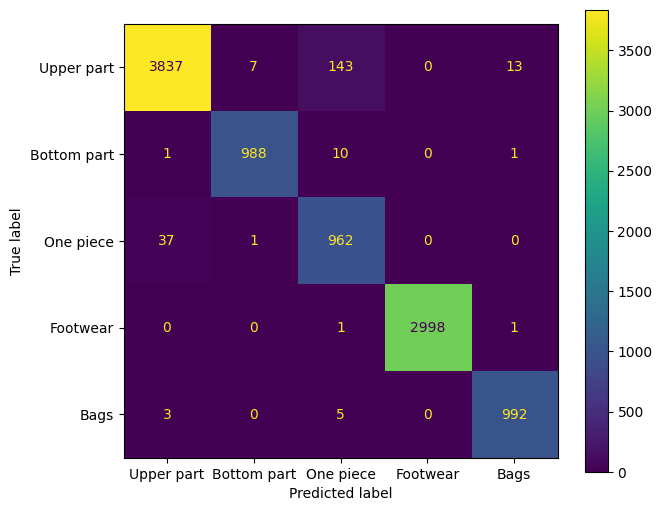

In [55]:
real = list(y_test_df['label'])
pred = [np.argmax(pred) for pred in test_predictions]

cm   = metrics.confusion_matrix(real, pred, labels=list(REVERSE_GROUP_MAPPING.keys()))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GROUP_MAPPING.keys())
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax)
plt.show()

## Slot for NOTES

* 02_zalando_image_classification_mobilenet_v2_baseline_non_layers_frozen:
  * "One piece" precision has improved
  * "One piece" FP has been reduced

## Error analysis

In [56]:
probabilities = [float(torch.max(proba)) for proba in test_predictions_proba]

y_test_df['pred_label']   = list(map(lambda x: REVERSE_GROUP_MAPPING[x], pred))
y_test_df['str_label']    = y_test_df['label'].apply(lambda x: REVERSE_GROUP_MAPPING[x])
y_test_df['proba_label']  = probabilities

y_test_df

,index,label,pred_label,str_label,proba_label
0,0,3,Footwear,Footwear,0.999972
1,1,0,Upper part,Upper part,0.998385
2,2,1,Bottom part,Bottom part,0.999728
3,3,1,Bottom part,Bottom part,0.999854
4,4,0,Upper part,Upper part,0.998422
...,...,...,...,...,...
9995,9995,3,Footwear,Footwear,0.999927
9996,9996,1,Bottom part,Bottom part,0.999469
9997,9997,4,Bags,Bags,0.999914
9998,9998,1,Bottom part,Bottom part,0.999611


* 02_zalando_image_classification_mobilenet_v2_baseline_non_layers_frozen: model still confuse One piece clothes with Upper part ones

In [57]:
y_test_df[(y_test_df['str_label'] == 'Upper part') &\
          (y_test_df['pred_label'] == 'One piece') &\
          (y_test_df['proba_label'] < 0.5)].sort_values('proba_label', ascending=True)

,index,label,pred_label,str_label,proba_label
3880,3880,0,One piece,Upper part,0.436852
3230,3230,0,One piece,Upper part,0.495911


In [58]:
indexes = list(y_test_df[(y_test_df['str_label'] == 'Upper part') &\
                         (y_test_df['pred_label'] == 'One piece') &\
                         (y_test_df['proba_label'] < 0.5)]['index']
               )

Image number 3230


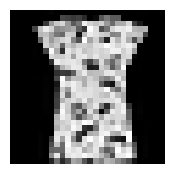

--------------------
Image number 3880


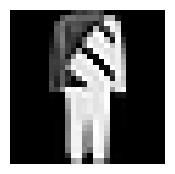

--------------------


In [59]:
for index_ in indexes:
  plt.figure(figsize=(2, 2))
  print("Image number {}".format(index_))
  image = np.load(NPY_FILES + 'test_image_{:05d}.npy'.format(index_))
  plt.imshow(image, cmap='gray', aspect='auto')
  plt.axis('off')
  plt.show()
  print("-" * 20)

## ExplainableAI with Shap

__Define chunk to run exAI with Shap values__

In [60]:
# -- Load model
best_model = torch.load(MODEL_NAME)
if torch.cuda.is_available():
  best_model.to('cuda')

# -- Define transform functions
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,))
])

# -- Define predict function
def predict(image):
    image  = torch.FloatTensor(image)
    if torch.cuda.is_available():
        image = image.cuda()
    output = model(image)
    return output

# -- 1. Create an explainer with model and image masker
# -- 2. Define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur({},{})".format(IMG_SIZE, IMG_SIZE), (3, IMG_SIZE, IMG_SIZE))

# -- Sample with image number 2191 (shirt)
explainer  = shap.Explainer(predict, masker_blur)
image_list = []
for index_ in indexes:
    if index_ == 3230:
      image = np.load(NPY_FILES + 'test_image_{:05d}.npy'.format(index_))
      image = torch.FloatTensor(image)
      image = transform(image)
      image = image.expand(3, image.size(1), image.size(2))
      image = torch.unsqueeze(image, 0)  # Añade la dimensión batch
      if torch.cuda.is_available():
          image = image.cuda()
      image_list.append(image)

shap_values = explainer(
    image_list[0],
    max_evals=1000,
    batch_size=1,
    outputs=shap.Explanation.argsort.flip[:1],
)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:34, 94.51s/it]               


In [61]:
# -- Define inverse transform function (to "unstandardize data")
inv_transform = [
    transforms.Normalize(
        mean=(-1 * np.array(MEAN) / np.array(STD)).tolist(),
        std=(1 / np.array(STD)).tolist(),
    )
]
shap_values_data = np.moveaxis((shap_values.data * STD + MEAN).cpu().numpy()[0], 0, -1)
shap_values_values = [np.moveaxis(val, 0, -1) for val in np.moveaxis(shap_values.values[0], -1, 0)]

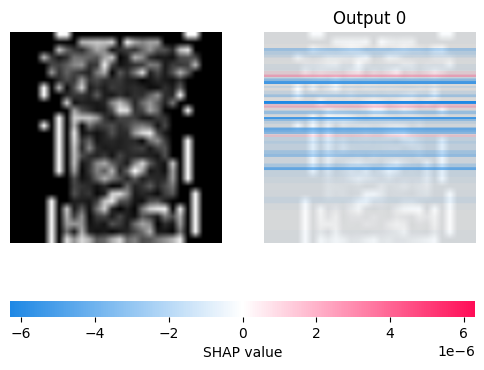

In [62]:
shap.image_plot(
    shap_values=shap_values_values,
    pixel_values=shap_values_data,
    labels=shap_values.output_names
)

## Conclusions for next experiments

* __After finetuning all layers, results have improved: specially with "One Piece" clothes__

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| Upper part       | 0.91  | 0.96      | 0.94                     | MobileNetV2 baseline (no img aug) - frozen layers |
|        | 0.89  | 0.94      | 0.93                     | MobileNetV2 baseline (best img aug) - frozen layers |
|        | __0.96__  | __0.99__     | __0.97__                     | MobileNetV2 baseline (no img aug) - non frozen layers |

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| Bottom part      | 0.96  | 0.97      | 1.0                      | MobileNetV2 baseline (no img aug) - frozen layers |
|     | 0.94  | 0.95      | 0.99                      | MobileNetV2 baseline (best img aug) - frozen layers |
|       | __0.99__  | __0.99__      | __1.0__                      | MobileNetV2 baseline (no img aug) - non frozen layers |

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| One piece        | 0.88  | 0.73      | 0.99                     | MobileNetV2 baseline (no img aug) - frozen layers |
|        | 0.8  | 0.67      | 0.98                     | MobileNetV2 baseline (best img aug) - frozen layers |
|        | __0.96__  | __0.86__      | __1.0__                     | MobileNetV2 baseline (no img aug) - non frozen layers |

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| Footwear         | 0.99  | 0.99      | 1.0                      | MobileNetV2 baseline (no img aug) - frozen layers |
|         | 0.98  | 0.99      | 0.99                      | MobileNetV2 baseline (best img aug) - frozen layers |
|         | __1.0__  | __1.0__      | __1.0__                      | MobileNetV2 baseline (no img aug) - non frozen layers |

|                  | recall | precision | negative predicted value | model |
|------------------|-------|-----------|--------------------------| -------- |
| Bags             | 0.96  | 0.92      | 1.0                      | MobileNetV2 baseline (no img aug) - frozen layers |
|             | 0.92  | 0.89      | 0.99                      | MobileNetV2 baseline (best img aug) - frozen layers |
|             | __0.99__  | __0.99__      | __1.0__                      | MobileNetV2 baseline (no img aug) - non frozen layers |

* __Baseline model achieves better results if we trained all weights__

* __Performance with best MobileNetV2 (no image augmentation + non frozen layers)__

|                  | number of parameters | model size (MB) | test inference time (seconds) |
|------------------|-------|-----------|--------------------------|
| MobilenetV2 - baseline | 2230277 | 8.8 MB | 37.6 sec |
| MobilenetV2 - baseline - no frozen layers | 2230277 | 8.8 MB | 37.3 sec |

* __Final experiment: What if we fine-tune a smaller version? E.g: MobileNetV3__

In [64]:
# Define test-inference function
def simple_test(test_data, model):
    print('Validating...')
    model.eval()
    prediction_proba_list = []
    label_list = []
    prediction_list = []
    with torch.no_grad():
      for input_data, label in tqdm(test_data):
          # Again, switch to GPU if available
          if torch.cuda.is_available():
              input_data, label = input_data.cuda(), label.cuda()

          label_numpy = label.detach().cpu().numpy()
          label_list.append(label_numpy)

          outputs  = model(input_data)

          # Apply softmax activation to get all the outputs between 0 and 1
          outputs_sig = F.softmax(outputs.data, dim=1).detach().cpu()
          prediction_list.append(maximize_index(outputs_sig.numpy()))
      # Get Sensitivity/Precision/NPV
      prediction_list = list(itertools.chain(*prediction_list))
      label_list      = list(itertools.chain(*label_list))

best_model = torch.load(MODEL_NAME)

In [65]:
%%time
# -- Sample inference-test function
simple_test(
        test_loader, best_model
)

Validating...


  0%|          | 0/625 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

CPU times: user 11.7 s, sys: 2.22 s, total: 13.9 s
Wall time: 37.3 s


In [44]:
params = sum([np.prod(p.size()) for p in best_model.parameters()])
params

2230277